<a href="https://colab.research.google.com/github/laura1machado1delostoyos/MSFTPricePrediction/blob/main/MSFT_Price_Prediction_MLPRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install yfinance
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
from datetime import datetime
from datetime import timedelta
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

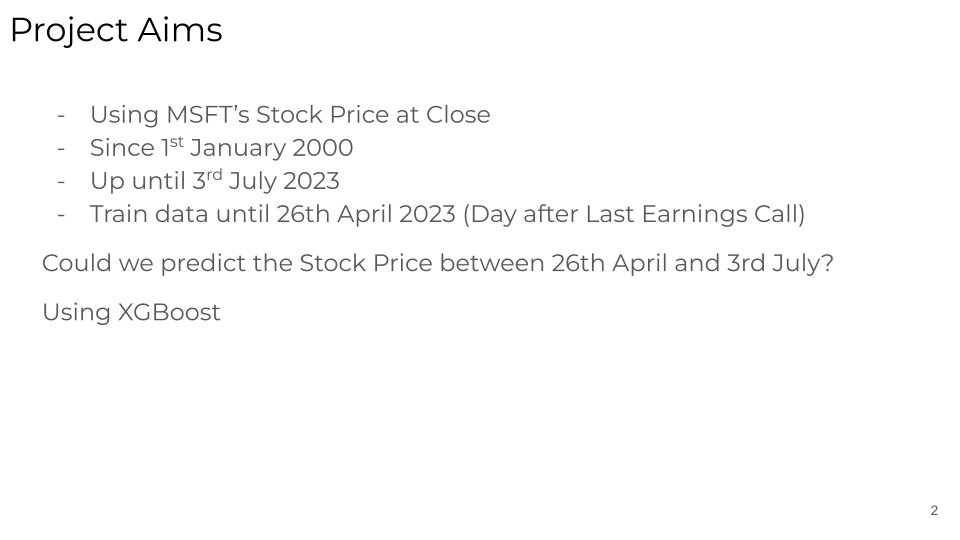

In [2]:
# Loaded the start date - This is the date from when the data will be uploaded - 1st Jan 2000
start_date = '2000-01-01'
start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')

# We will train the model up until the 3rd of July, and then predict on the 10th of July

# The end_date is the last day for which we will load training data - 3rd July 2023
end_date = '2023-07-03'
end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')

# The target date is the date for which we want to predict the stock price - 10th July 2023
target_date = '2023-07-10'
target_date_dt = datetime.strptime(target_date, '%Y-%m-%d')

### Loading MSFT Data up until 10th July

In [3]:
# Choose the ticker symbol
tickerSymbol = 'MSFT'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
# We want to load the data up until the 10th July - we will restrict the dataframe to the 3rd July later
msft = tickerData.history(period='1d', start= start_date_dt, end= (target_date_dt + timedelta(days = 1))) #We need to add 1 day to the end of the range so that the time range goes up to the desired target date

# Visualise
msft

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03 00:00:00-05:00,36.457968,36.846232,34.788434,36.205597,53228400,0.0,0.0
2000-01-04 00:00:00-05:00,35.273769,36.380320,34.866092,34.982571,54119000,0.0,0.0
2000-01-05 00:00:00-05:00,34.516639,36.147347,33.973070,35.351406,64059600,0.0,0.0
2000-01-06 00:00:00-05:00,34.846675,35.370831,33.662471,34.167213,54976600,0.0,0.0
2000-01-07 00:00:00-05:00,33.740130,34.866095,33.332453,34.613724,62013600,0.0,0.0
...,...,...,...,...,...,...,...
2023-07-03 00:00:00-04:00,338.473386,340.179765,335.858927,337.275909,12508700,0.0,0.0
2023-07-05 00:00:00-04:00,334.382045,340.928183,334.022820,337.435577,18172400,0.0,0.0
2023-07-06 00:00:00-04:00,336.587367,342.265348,334.791182,340.548981,28161200,0.0,0.0


In [4]:
# Let's isolate the column with the closing price, as we will not be using be using any of the other columns in this data frame
msft = msft[['Close']]

# Resetting the date index so that we can manipulate the daytime object to contain a year-month-day formatted date
# msft = msft.reset_index()
# msft['Date'] = msft['Date'].dt.date
# msft = msft.set_index('Date')

# Send the Close column is what we are going to use as an indicator for the price, we can rename it for greater clarity
msft = msft.rename(columns = {'Close': 'Price'})
msft

,Price
Date,
2000-01-03 00:00:00-05:00,36.205597
2000-01-04 00:00:00-05:00,34.982571
2000-01-05 00:00:00-05:00,35.351406
2000-01-06 00:00:00-05:00,34.167213
2000-01-07 00:00:00-05:00,34.613724
...,...
2023-07-03 00:00:00-04:00,337.275909
2023-07-05 00:00:00-04:00,337.435577
2023-07-06 00:00:00-04:00,340.548981


In [5]:
msft.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5916 entries, 2000-01-03 00:00:00-05:00 to 2023-07-10 00:00:00-04:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   5916 non-null   float64
dtypes: float64(1)
memory usage: 92.4 KB


Now, let's restrict the data frame to the last day of trading that we will feed into our model, eg the `end_date` of the 3rd July 2023



In [6]:
# Then, restrict the df
df = msft[:end_date]

# Remove the timezone information and set the time to midnight
df.index = df.index.tz_convert(None).normalize()

df

,Price
Date,
2000-01-03,36.205597
2000-01-04,34.982571
2000-01-05,35.351406
2000-01-06,34.167213
2000-01-07,34.613724
...,...
2023-06-27,333.863159
2023-06-28,335.140442
2023-06-29,334.342102


In [7]:
df['Price'].iloc[0:3]

Date
2000-01-03    36.205597
2000-01-04    34.982571
2000-01-05    35.351406
Name: Price, dtype: float64

# Initialise randomised sampling to create an input and output array

In [8]:
# Initialize lists to store input and output sequences
input_sequences = []
output_sequences = []

In [9]:
# Define the sequence length (12 for input, 13 for output)
sequence_length = 12

In [10]:
# Iterate through the data to create sequences
for i in range(len(df['Price']) - sequence_length - 1): #Iterate through the first 5899 rowss and leave the last 13 rows alone
    input_seq = df['Price'].iloc[i:i + sequence_length]  # Get (the rolling) 12 rows from the Price column and add them to a Pandas Series called `input seq`.
    output_seq = df['Price'].iloc[i + sequence_length]  # Get the corresponding 13th output value and add it to a Pandas Series called `output_seq`
    input_sequences.append(list(input_seq))
    output_sequences.append(output_seq)

In [11]:
# Convert the lists to NumPy arrays
input_sequences = np.array(input_sequences)
output_sequences = np.array(output_sequences)

## Separate the input & output sequences into Training and Testing

In [12]:
# Pick the % of the dataset that we want to set aside for testing
pct_testing = 20

# Convert it into an index location in the input array for slicing
slicing_index = len(input_sequences) * pct_testing/100  #this makes a float so it needs to be casted onto an `int`
slicing_index = int(slicing_index)


# Slice the input and output sequences to separate training and test data
X_train = input_sequences[:-slicing_index]
y_train = output_sequences[:-slicing_index]
X_test = input_sequences[-slicing_index:]
y_test = output_sequences[-slicing_index:]

### What this is doing:
![](https://drive.google.com/uc?export=view&id=1DmAs743q67xDinxbiVE_DLVZn61IjtLo)

In [13]:
X_train

array([[ 36.20559692,  34.98257065,  35.3514061 , ...,  34.86610031,
         35.81733322,  33.23538208],
       [ 34.98257065,  35.3514061 ,  34.16721344, ...,  35.81733322,
         33.23538208,  32.92476654],
       [ 35.3514061 ,  34.16721344,  34.61372375, ...,  33.23538208,
         32.92476654,  32.22590637],
       ...,
       [109.09675598, 109.11569977, 106.86080933, ..., 101.94363403,
        105.16491699, 104.89013672],
       [109.11569977, 106.86080933, 106.23550415, ..., 105.16491699,
        104.89013672, 102.79633331],
       [106.86080933, 106.23550415, 105.022789  , ..., 104.89013672,
        102.79633331, 102.94791412]])

# Create MLP Regressor Model

## Create a Preliminary Model and Observe Performance

In [14]:
from sklearn.neural_network import MLPRegressor

In [15]:
model = MLPRegressor()

In [16]:
model.fit(X_train, y_train)

MLPRegressor()

In [17]:
y_pred = model.predict(X_test)

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R-squared (R2) score
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"RMSE: {rmse}")
print(f"R-squared (R2) Score: {r2}")


Mean Squared Error (MSE): 21.185940954170878
Mean Absolute Error (MAE): 3.3086336541953254
RMSE: 4.602818805272578
R-squared (R2) Score: 0.995596314926688


### Compare model predictions with `y_test`

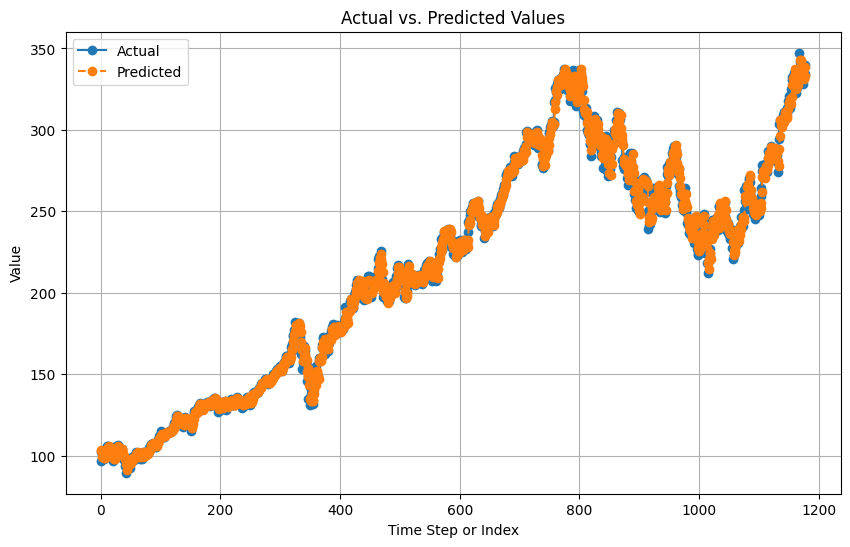

In [19]:
# Create an array for the x-axis (indices or time steps)
x = np.arange(len(y_test))

# Create a line plot for y_pred and y_test
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(x, y_test, label='Actual', marker='o', linestyle='-')
plt.plot(x, y_pred, label='Predicted', marker='o', linestyle='--')

# Add labels and a legend
plt.xlabel('Time Step or Index')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.show()


In [20]:
score = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE Score on Test set: {score:0.2f}')
print(f'R^2 Score on Test set: {r2:0.2f}')

RMSE Score on Test set: 4.60
R^2 Score on Test set: 1.00


## Cross-Validation of Regressor Parameters

In [21]:
param_grid = {'max_iter': [2, 5, 10, 12, 15, 17, 20],
              'hidden_layer_sizes': [(2,), (4,), (8,), (10,), (12,), (14,), (16,)]}

In [22]:
from sklearn.preprocessing import MinMaxScaler
# Use MinMaxScaler to scale the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Scaling the training data


In [23]:
param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (100,), (50, 50), (100, 50, 10)],
    'max_iter': [500, 1000, 2000],
    'solver': ['adam', 'lbfgs', 'sgd'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'alpha': [0.0001, 0.001, 0.01]
}


In [24]:
regressor = GridSearchCV(
    estimator = MLPRegressor(),
    param_grid = param_grid,
    n_jobs = 4
)
regressor.fit(X_train_scaled, y_train) #Feed the scaled training set into here
print(regressor.best_score_)
print(regressor.best_estimator_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 2025.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 749, in fit
    return self._fit(X, y, incremental=False)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 491, in _fit
    raise ValueError(
ValueError: S

0.9884460051499804
MLPRegressor(alpha=0.001, learning_rate_init=0.01, max_iter=2000,
             solver='lbfgs')


In [25]:
from sklearn.preprocessing import MinMaxScaler

# Assume 'scaler' is the MinMaxScaler applied to your data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Scaling the training data

# Train your model with the scaled data

# Make predictions on new data
X_new_scaled = scaler.transform(X_new)  # Scale the new data

# Assuming 'predictions' are the predictions made on scaled data
predictions_original_scale = scaler.inverse_transform(predictions)  # Scale predictions back to original


NameError: ignored

started 19.32

In [ ]:
# grid_search = GridSearchCV(estimator=xgb.XGBRegressor(),
#                            param_grid=param_grid,
#                            scoring='r2',
#                            cv=5,
#                            verbose=2,
#                            n_jobs=-1)

# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_

The cell above takes 1h40min to run. Below is a screenshot of the output.

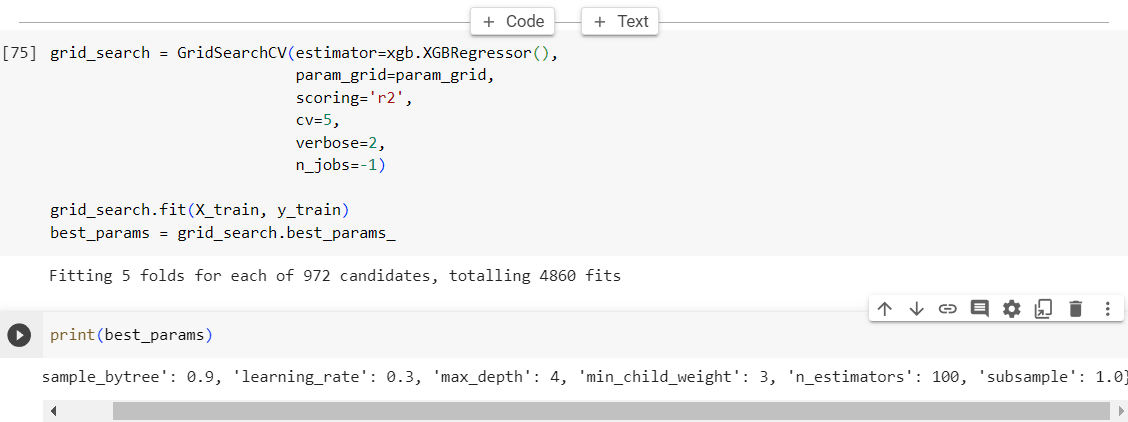

The output of this cell has been saved in a new variable `best_params_saved_1st`

In [ ]:
best_params_saved_1st = {'colsample_bytree': 0.9, 'learning_rate': 0.3, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}

In [ ]:
print(best_params_saved_1st)

In [ ]:
param_grid_2nd = {
    'learning_rate': [0.25, 0.3, 0.4, 0.5],
    'max_depth': [4],
    'n_estimators': [50, 75, 100],
    'min_child_weight': [2, 3, 4],
    'subsample': [0.95, 0.975, 1.0],
    'colsample_bytree': [0.85, 0.9, 0.95]
}

In [ ]:
# grid_search = GridSearchCV(estimator=xgb.XGBRegressor(),
#                            param_grid=param_grid_2nd,
#                            scoring='r2',
#                            cv=5,
#                            verbose=2,
#                            n_jobs=-1)

# grid_search.fit(X_train, y_train)
# best_params = grid_search.best_params_

In [ ]:
# print(best_params)

The above code took 14 minutes to run and had the following output:
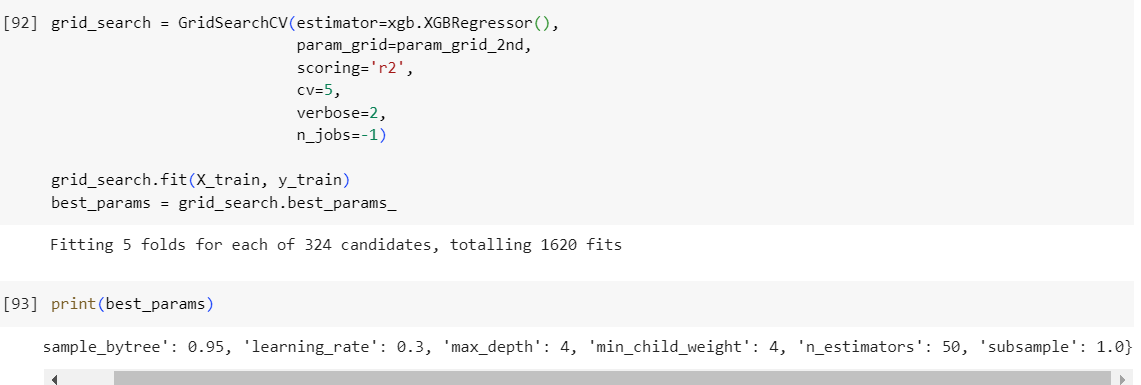

These parameters have been saved in the variable `best_params_2nd`.

In [ ]:
best_params_2nd = {'colsample_bytree': 0.95, 'learning_rate': 0.3, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 50, 'subsample': 1.0}

Now, let's use these parameters to fit our model

In [ ]:
best_model = xgb.XGBRegressor(**best_params_2nd)
best_model.fit(X_train, y_train)

In [ ]:
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [ ]:
print(f'RMSE Score on Test set: {rmse:0.2f}')
print(f'R^2 Score on Test set: {r2:0.2f}')

In [ ]:
# Create an array for the x-axis (indices or time steps)
x = np.arange(len(y_test))

# Create a line plot for y_pred and y_test
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(x, y_test, label='Actual', marker='o', linestyle='-')
plt.plot(x, y_pred, label='Predicted', marker='o', linestyle='--')

# Add labels and a legend
plt.xlabel('Time Step or Index')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.show()

# Predict the price on 10th July 2023 off the out-of-the-box model

In [ ]:
trading_dates = msft[end_date:target_date].index.tz_convert(None).normalize()
trading_dates

In [ ]:
# Extend the sequences up to the 10th of July
extended_input_sequences = input_sequences.copy()  # Make a copy of the input sequences
extended_output_sequences = output_sequences.copy()  # Make a copy of the output sequences

In [ ]:
for date in trading_dates:
    # Predict for the next day
    prediction = model.predict(extended_input_sequences[-1].reshape(1, -1))  # Predict for the last sequence
    extended_input_sequences = np.vstack((extended_input_sequences, np.append(extended_input_sequences[-1, 1:], prediction)))
    extended_output_sequences = np.append(extended_output_sequences, prediction)

# Print or use the predictions for July 4th to July 10th
print("Predictions for July 10th:", extended_output_sequences[-1])